In [ ]:
import pandas as pd
df = pd.read_csv('/content/T_ONTIME_REPORTING 2.csv')
print(df.head())


   YEAR  QUARTER  MONTH               FL_DATE OP_UNIQUE_CARRIER  \
0  2025        1      1  1/1/2025 12:00:00 AM                AA   
1  2025        1      1  1/1/2025 12:00:00 AM                AA   
2  2025        1      1  1/1/2025 12:00:00 AM                AA   
3  2025        1      1  1/1/2025 12:00:00 AM                AA   
4  2025        1      1  1/1/2025 12:00:00 AM                AA   

   OP_CARRIER_AIRLINE_ID OP_CARRIER  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
0                  19805         AA                  1              12478   
1                  19805         AA                 10              12892   
2                  19805         AA               1002              13485   
3                  19805         AA               1004              14100   
4                  19805         AA               1005              13930   

   ORIGIN_AIRPORT_SEQ_ID  ...  CANCELLED CANCELLATION_CODE DIVERTED  \
0                1247805  ...        0.0               NaN     

In [ ]:
print(df.head())
print(df.info())
print(df.describe())


   YEAR  QUARTER  MONTH               FL_DATE OP_UNIQUE_CARRIER  \
0  2025        1      1  1/1/2025 12:00:00 AM                AA   
1  2025        1      1  1/1/2025 12:00:00 AM                AA   
2  2025        1      1  1/1/2025 12:00:00 AM                AA   
3  2025        1      1  1/1/2025 12:00:00 AM                AA   
4  2025        1      1  1/1/2025 12:00:00 AM                AA   

   OP_CARRIER_AIRLINE_ID OP_CARRIER  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
0                  19805         AA                  1              12478   
1                  19805         AA                 10              12892   
2                  19805         AA               1002              13485   
3                  19805         AA               1004              14100   
4                  19805         AA               1005              13930   

   ORIGIN_AIRPORT_SEQ_ID  ...  CANCELLED CANCELLATION_CODE DIVERTED  \
0                1247805  ...        0.0               NaN     

Remove Duplicates and Cancelled/Diverted Flights

In [ ]:
df = df.drop_duplicates()


In [ ]:
df = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)]

Handle Missing Values

In [ ]:
df = df[df['ARR_DEL15'].notnull()]


In [ ]:
df.fillna(df.median(numeric_only=True), inplace=True)


Create & Select Features

In [ ]:
df['DELAYED'] = df['ARR_DEL15'].astype(int)


In [ ]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek


In [ ]:
import pandas as pd
df = pd.read_csv('/content/T_ONTIME_REPORTING 2.csv')

# Remove Duplicates and Cancelled/Diverted Flights
df = df.drop_duplicates()
df = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)]

# Handle Missing Values
df = df[df['ARR_DEL15'].notnull()]
df.fillna(df.median(numeric_only=True), inplace=True)

# Create DELAYED feature
df['DELAYED'] = df['ARR_DEL15'].astype(int)

# Create DAY_OF_WEEK feature
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%m/%d/%Y %I:%M:%S %p')
df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek


features_to_keep = [
    'FL_DATE', 'MONTH', 'DAY_OF_WEEK', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_TIME_BLK',
    'TAXI_OUT', 'DISTANCE', 'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID'
]
df = df[features_to_keep + ['DELAYED']]

Encode Categorical Variables

In [ ]:
df = pd.get_dummies(df, columns=['OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME_BLK'], drop_first=True)

Scale Numerical Features

In [ ]:
from sklearn.preprocessing import StandardScaler

num_features = ['DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'DISTANCE']
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])


Handle Class Imbalance

In [ ]:
from imblearn.over_sampling import SMOTE

X = df.drop('DELAYED', axis=1)
y = df['DELAYED']

X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)


Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


 Import Required Libraries

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


Train Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Train Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

Train Stacking Classifier (Random Forest + GB + Logistic Regression)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_train, y_train)


StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

def evaluate(model, name):
    y_pred = model.predict(X_test)
    print(f"\n📊 {name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

evaluate(rf, "Random Forest")
evaluate(gb, "Gradient Boosting")
evaluate(stack, "Stacking Classifier")



📊 Random Forest Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1304
           1       0.97      0.98      0.97      1303

    accuracy                           0.97      2607
   macro avg       0.97      0.97      0.97      2607
weighted avg       0.97      0.97      0.97      2607

Accuracy: 0.9743
F1-score: 0.9744

📊 Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1304
           1       0.95      0.94      0.94      1303

    accuracy                           0.94      2607
   macro avg       0.94      0.94      0.94      2607
weighted avg       0.94      0.94      0.94      2607

Accuracy: 0.9444
F1-score: 0.9442

📊 Stacking Classifier Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1304
           1       0.98      0.98      0.98      1303

    accuracy  

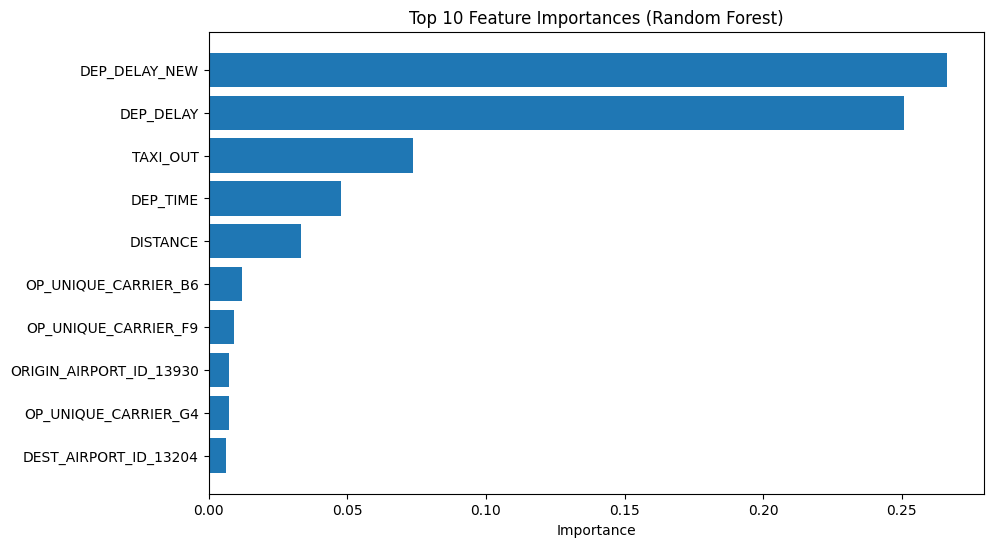

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10
feature_names = X_train.columns[indices]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), feature_names)
plt.xlabel('Importance')
plt.show()


Load Required Libraries & model

In [ ]:
import joblib
joblib.dump(stack, "flight_delay_predictor_model.pkl")
joblib.dump(X_train.columns, "X_train_columns.pkl")


['X_train_columns.pkl']

predict and display output

In [ ]:
import pandas as pd
import joblib

# Load the saved model and column names
model = joblib.load("flight_delay_predictor_model.pkl")
columns = joblib.load("X_train_columns.pkl")


# Show allowed categorical inputs
carrier_cols = [col.replace("OP_UNIQUE_CARRIER_", "") for col in columns if col.startswith("OP_UNIQUE_CARRIER_")]
timeblk_cols = [col.replace("DEP_TIME_BLK_", "") for col in columns if col.startswith("DEP_TIME_BLK_")]

print("✅ Available Carriers:", ", ".join(carrier_cols))
print("⏰ Available Time Blocks:", ", ".join(timeblk_cols))

# Take user input
print("\n✈️ Please Enter Flight Information:")
month = int(input("Enter MONTH (1-12): "))
day_of_week = int(input("Enter DAY OF WEEK (0=Mon, 6=Sun): "))
dep_time = int(input("Enter DEPARTURE TIME (e.g., 1330 for 1:30 PM): "))
dep_delay = float(input("Enter DEPARTURE DELAY (in minutes): "))
taxi_out = float(input("Enter TAXI OUT time (in minutes): "))
distance = float(input("Enter DISTANCE (in miles): "))
carrier = input("Enter CARRIER CODE from above list: ").strip().upper()
time_blk = input("Enter DEPARTURE TIME BLOCK from above list: ").strip()

# Create an input DataFrame with 0s
new_data = pd.DataFrame(columns=columns)
new_data.loc[0] = 0

# Fill numeric features
new_data.at[0, 'MONTH'] = month
new_data.at[0, 'DAY_OF_WEEK'] = day_of_week
new_data.at[0, 'DEP_TIME'] = dep_time
new_data.at[0, 'DEP_DELAY'] = dep_delay
new_data.at[0, 'DEP_DELAY_NEW'] = dep_delay
new_data.at[0, 'TAXI_OUT'] = taxi_out
new_data.at[0, 'DISTANCE'] = distance

# Set one-hot encoded columns
carrier_col = f"OP_UNIQUE_CARRIER_{carrier}"
time_blk_col = f"DEP_TIME_BLK_{time_blk}"

for col in [carrier_col, time_blk_col]:
    if col in new_data.columns:
        new_data.at[0, col] = 1
    else:
        print(f"⚠️ Warning: '{col}' not found in training data. This might affect prediction.")

# Predict
prob = model.predict_proba(new_data)[0][1]
pred = model.predict(new_data)[0]

# Output result
print("\n📡 Prediction Result:")
print(f"🧪 Probability of delay: {round(prob * 100, 2)}%")
if pred == 1:
    print("🔴 The flight is likely to be DELAYED.")
else:
    print("🟢 The flight is likely to be ON TIME.")

✅ Available Carriers: AS, B6, DL, F9, G4, HA, MQ, NK
⏰ Available Time Blocks: 0600-0659, 0700-0759, 0800-0859, 0900-0959, 1000-1059, 1100-1159, 1200-1259, 1300-1359, 1400-1459, 1500-1559, 1600-1659, 1700-1759, 1800-1859, 1900-1959, 2000-2059, 2100-2159, 2200-2259, 2300-2359

✈️ Please Enter Flight Information:
Enter MONTH (1-12): 7
Enter DAY OF WEEK (0=Mon, 6=Sun): 5
Enter DEPARTURE TIME (e.g., 1330 for 1:30 PM): 1330
Enter DEPARTURE DELAY (in minutes): 40
Enter TAXI OUT time (in minutes): 12
Enter DISTANCE (in miles): 800
Enter CARRIER CODE from above list: DL
Enter DEPARTURE TIME BLOCK from above list: 1300-1359

📡 Prediction Result:
🧪 Probability of delay: 94.4%
🔴 The flight is likely to be DELAYED.


Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error



In [ ]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"📊 Evaluation Report for {name}:")
    print("--------------------------------------------------")
    print("Accuracy       :", round(acc, 4))
    print("Precision      :", round(prec, 4))
    print("Recall         :", round(rec, 4))
    print("F1-score       :", round(f1, 4))
    print("RMSE           :", round(rmse, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("--------------------------------------------------\n")

    return {
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'RMSE': rmse
    }


In [ ]:
results = []
results.append(evaluate_model("Random Forest", rf, X_test, y_test))
results.append(evaluate_model("Gradient Boosting", gb, X_test, y_test))
results.append(evaluate_model("Stacking Classifier", stack, X_test, y_test))

📊 Evaluation Report for Random Forest:
--------------------------------------------------
Accuracy       : 0.9743
Precision      : 0.9718
Recall         : 0.977
F1-score       : 0.9744
RMSE           : 0.1603
Confusion Matrix:
 [[1267   37]
 [  30 1273]]
--------------------------------------------------

📊 Evaluation Report for Gradient Boosting:
--------------------------------------------------
Accuracy       : 0.9444
Precision      : 0.9468
Recall         : 0.9417
F1-score       : 0.9442
RMSE           : 0.2358
Confusion Matrix:
 [[1235   69]
 [  76 1227]]
--------------------------------------------------

📊 Evaluation Report for Stacking Classifier:
--------------------------------------------------
Accuracy       : 0.977
Precision      : 0.9762
Recall         : 0.9777
F1-score       : 0.977
RMSE           : 0.1517
Confusion Matrix:
 [[1273   31]
 [  29 1274]]
--------------------------------------------------



Model Comparison summary

In [ ]:
import pandas as pd

comparison_df = pd.DataFrame(results)
print("Model Comparison Summary:\n")
print(comparison_df.sort_values(by="F1-score", ascending=False).reset_index(drop=True))


Model Comparison Summary:

                 Model  Accuracy  Precision    Recall  F1-score      RMSE
0  Stacking Classifier  0.976985   0.976245  0.977744  0.976994  0.151707
1        Random Forest  0.974300   0.971756  0.976976  0.974359  0.160312
2    Gradient Boosting  0.944381   0.946759  0.941673  0.944209  0.235838


Add the holiday column

In [ ]:
import holidays
us_holidays = holidays.US()
# Create the is_holiday column after merging with weather data
merged_df['is_holiday'] = merged_df['FL_DATE'].apply(lambda x: 1 if x in holidays.US() else 0)

Add the wheather data

In [ ]:
import pandas as pd
import numpy as np

# Load your BTS dataset
df = pd.read_csv('/content/T_ONTIME_REPORTING 2.csv')

# Step 1: Extract unique date + origin combinations
weather_keys = df[['FL_DATE', 'ORIGIN_AIRPORT_ID']].drop_duplicates()

# Step 2: Simulate weather data
np.random.seed(42)
weather_data = weather_keys.copy()
weather_data['temperature'] = np.random.normal(loc=50, scale=15, size=len(weather_keys)).round(1)
weather_data['wind_speed'] = np.random.normal(loc=10, scale=5, size=len(weather_keys)).round(1)
weather_data['precipitation'] = np.random.exponential(scale=0.2, size=len(weather_keys)).round(2)

# Optional: Cap values to realistic limits
weather_data['wind_speed'] = weather_data['wind_speed'].clip(lower=0)
weather_data['precipitation'] = weather_data['precipitation'].clip(upper=1)

# Step 3: Save to CSV
weather_data.to_csv('/content/weather_2025.csv', index=False)

# Show sample
weather_data.head()


,FL_DATE,ORIGIN_AIRPORT_ID,temperature,wind_speed,precipitation
0,1/1/2025 12:00:00 AM,12478,57.5,8.6,0.51
1,1/1/2025 12:00:00 AM,12892,47.9,18.1,0.11
2,1/1/2025 12:00:00 AM,13485,59.7,14.7,0.07
3,1/1/2025 12:00:00 AM,14100,72.8,14.7,0.02
4,1/1/2025 12:00:00 AM,13930,46.5,11.8,0.13


In [ ]:
# Check the info of the merged DataFrame to see non-null counts
print(merged_df.info())

# Display the first few rows of the merged DataFrame, including weather columns
print("\nFirst 10 rows of the merged DataFrame with weather data:")
display(merged_df[['FL_DATE', 'ORIGIN_AIRPORT_ID', 'temperature', 'wind_speed', 'precipitation']].head(10))

# Check the number of missing values in the weather columns
print("\nMissing values in weather columns after merge:")
print(merged_df[['temperature', 'wind_speed', 'precipitation']].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539747 entries, 0 to 539746
Data columns (total 50 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   YEAR                   539747 non-null  int64         
 1   QUARTER                539747 non-null  int64         
 2   MONTH                  539747 non-null  int64         
 3   FL_DATE                539747 non-null  datetime64[ns]
 4   OP_UNIQUE_CARRIER      539747 non-null  object        
 5   OP_CARRIER_AIRLINE_ID  539747 non-null  int64         
 6   OP_CARRIER             539747 non-null  object        
 7   OP_CARRIER_FL_NUM      539747 non-null  int64         
 8   ORIGIN_AIRPORT_ID      539747 non-null  int64         
 9   ORIGIN_AIRPORT_SEQ_ID  539747 non-null  int64         
 10  ORIGIN_CITY_MARKET_ID  539747 non-null  int64         
 11  ORIGIN_CITY_NAME       539747 non-null  object        
 12  ORIGIN_STATE_ABR       539747 non-null  obje

,FL_DATE,ORIGIN_AIRPORT_ID,temperature,wind_speed,precipitation
0,2025-01-01,12478,57.5,8.6,0.51
1,2025-01-01,12892,47.9,18.1,0.11
2,2025-01-01,13485,59.7,14.7,0.07
3,2025-01-01,14100,72.8,14.7,0.02
4,2025-01-01,13930,46.5,11.8,0.13
5,2025-01-01,11109,46.5,4.4,0.58
6,2025-01-01,11298,73.7,9.8,0.16
7,2025-01-01,11057,61.5,14.9,0.22
8,2025-01-01,12953,43.0,3.7,0.02
9,2025-01-01,11503,58.1,13.2,0.03



Missing values in weather columns after merge:
temperature      0
wind_speed       0
precipitation    0
dtype: int64


Dispaly the holiday or not

In [ ]:
# Display the first few rows including the new 'is_holiday' column
print("First 10 rows with 'is_holiday' column:")
display(merged_df[['FL_DATE', 'is_holiday']].head(10))

# Check the info to confirm the column exists and has data
print("\nDataFrame Info with 'is_holiday' column:")
print(merged_df.info())

# Check the value counts of the 'is_holiday' column
print("\nValue counts for 'is_holiday' column:")
print(merged_df['is_holiday'].value_counts())

First 10 rows with 'is_holiday' column:


,FL_DATE,is_holiday
0,2025-01-01,1
1,2025-01-01,1
2,2025-01-01,1
3,2025-01-01,1
4,2025-01-01,1
5,2025-01-01,1
6,2025-01-01,1
7,2025-01-01,1
8,2025-01-01,1
9,2025-01-01,1



DataFrame Info with 'is_holiday' column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539747 entries, 0 to 539746
Data columns (total 51 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   YEAR                   539747 non-null  int64         
 1   QUARTER                539747 non-null  int64         
 2   MONTH                  539747 non-null  int64         
 3   FL_DATE                539747 non-null  datetime64[ns]
 4   OP_UNIQUE_CARRIER      539747 non-null  object        
 5   OP_CARRIER_AIRLINE_ID  539747 non-null  int64         
 6   OP_CARRIER             539747 non-null  object        
 7   OP_CARRIER_FL_NUM      539747 non-null  int64         
 8   ORIGIN_AIRPORT_ID      539747 non-null  int64         
 9   ORIGIN_AIRPORT_SEQ_ID  539747 non-null  int64         
 10  ORIGIN_CITY_MARKET_ID  539747 non-null  int64         
 11  ORIGIN_CITY_NAME       539747 non-null  object        
 12  OR